Лабораторна робота №2 з курсу "Основи технологій машинного навчання"

Виконав: студент гр.ТІ-72, Фокін Андрій Віталійович

Навчання моделі проводилося в Google Colab

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 15.0MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 54.2MB/s 
     |████████████████████████████████| 194kB 56.7MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '4a8c886952e445be9a4f7bb4601f9797')

In [5]:
search_images_bing

<function fastbook.search_images_bing>

In [6]:
results = search_images_bing(key, 'airplane')
ims = results.attrgot('content_url')
len(ims)

150

In [7]:
#hide
ims = ['https://www.irmi.com/images/default-source/article-images/aviation/boeing-737.jpg?sfvrsn=4']

In [8]:
dest = 'S:\images\airplane.jpg'
download_url(ims[0], dest)

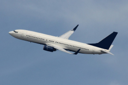

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
bird_types = 'airplane','helicopter','drone'
path = Path('aircrafts')

In [11]:
if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} aircraft')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#425) [Path('aircrafts/helicopter/00000120.jpg'),Path('aircrafts/helicopter/00000003.jpg'),Path('aircrafts/helicopter/00000073.jpg'),Path('aircrafts/helicopter/00000051.JPG'),Path('aircrafts/helicopter/00000137.jpg'),Path('aircrafts/helicopter/00000017.jpg'),Path('aircrafts/helicopter/00000127.jpg'),Path('aircrafts/helicopter/00000122.jpg'),Path('aircrafts/helicopter/00000034.jpg'),Path('aircrafts/helicopter/00000046.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#11) [Path('aircrafts/helicopter/00000044.jpg'),Path('aircrafts/helicopter/00000013.jpg'),Path('aircrafts/helicopter/00000111.jpg'),Path('aircrafts/helicopter/00000015.jpg'),Path('aircrafts/helicopter/00000001.jpg'),Path('aircrafts/helicopter/00000138.jpg'),Path('aircrafts/helicopter/00000063.jpg'),Path('aircrafts/helicopter/00000144.png'),Path('aircrafts/helicopter/00000123.jpg'),Path('aircrafts/airplane/00000126.jpg')...]

In [14]:
failed.map(Path.unlink);

From Data to DataLoaders

In [15]:
aircrafts = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = aircrafts.dataloaders(path)

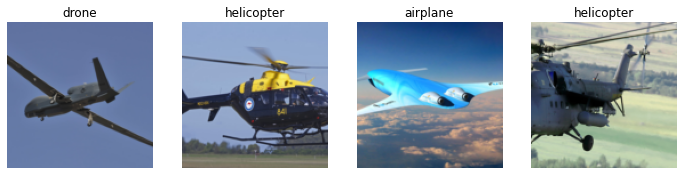

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

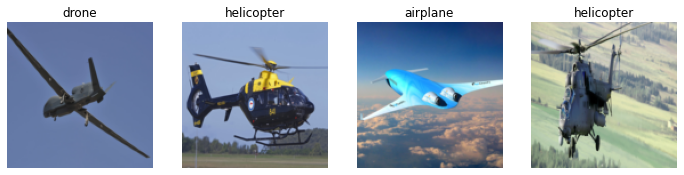

In [18]:
aircrafts = aircrafts.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = aircrafts.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

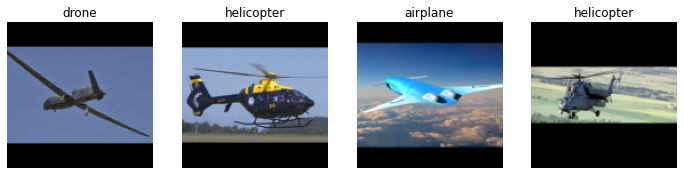

In [19]:
aircrafts = aircrafts.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = aircrafts.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

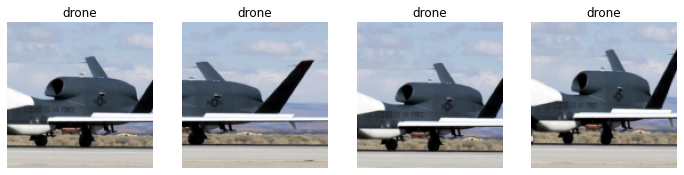

In [20]:
aircrafts = aircrafts.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = aircrafts.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data Augmentation

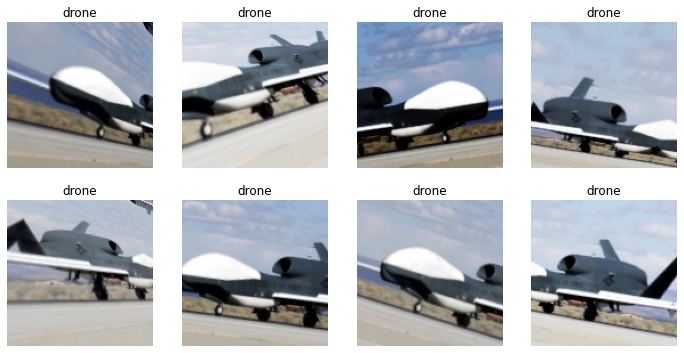

In [21]:
aircrafts = aircrafts.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = aircrafts.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Training Your Model, and Using It to Clean Your Data

In [22]:
aircrafts = aircrafts.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = aircrafts.dataloaders(path)

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.737311,0.911686,0.365854,00:15


epoch,train_loss,valid_loss,error_rate,time
0,1.090875,0.703334,0.304878,00:15
1,0.876237,0.696747,0.304878,00:15
2,0.729099,0.757601,0.280488,00:15
3,0.625571,0.743004,0.280488,00:15


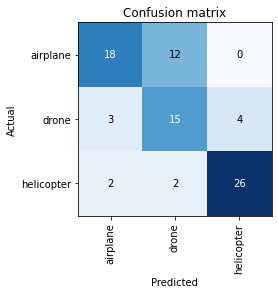

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

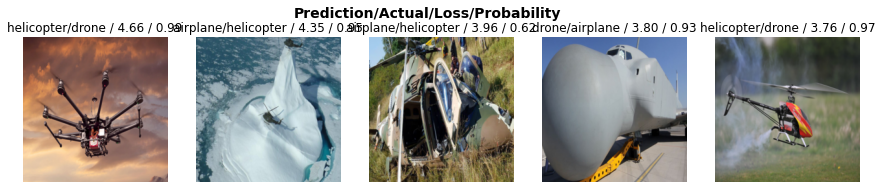

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Turning Your Model into an Online Application

Using the Model for Inference

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [31]:
learn_inf.predict('S:\images\airplane.jpg')

('airplane', tensor(0), tensor([9.9855e-01, 7.5832e-04, 6.9663e-04]))

In [32]:
learn_inf.dls.vocab

['airplane', 'drone', 'helicopter']

Creating a Notebook App from the Model

In [33]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [34]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['S:\images\airplane.jpg'])

In [35]:
img = PILImage.create(btn_upload.data[-1])

In [36]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: airplane; Probability: 0.9985')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [40]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [41]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label('Select your aircraft!'), 
      btn_upload, btn_run, out_pl, lbl_pred])